In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [111]:
df_model = pd.read_csv('results_model.csv', index_col = 0)
df_agents = pd.read_csv('results_agents.csv', index_col = [0, 1])

In [112]:
sample_agent_1 = df_agents.loc[(slice(None) , 1) , :].reset_index(level = 1, drop = True)
sample_agent_2 = df_agents.loc[(slice(None) , 2) , :].reset_index(level = 1, drop = True)

Text(0.5, 0, 'time')

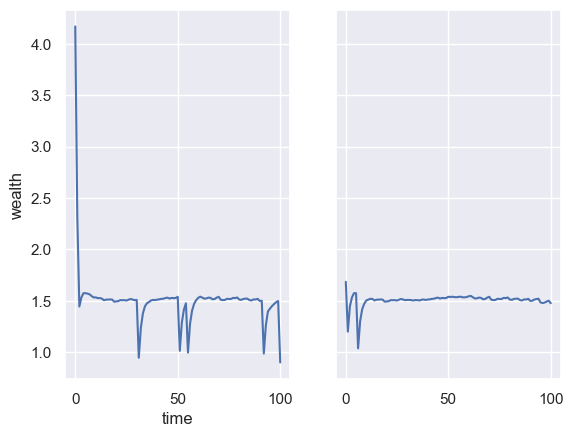

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
ax[0].plot(sample_agent_1.wealth)
ax[1].plot(sample_agent_2.wealth)
ax[0].set_ylabel('wealth')
ax[0].set_xlabel('time')

Text(0.5, 0, 'time')

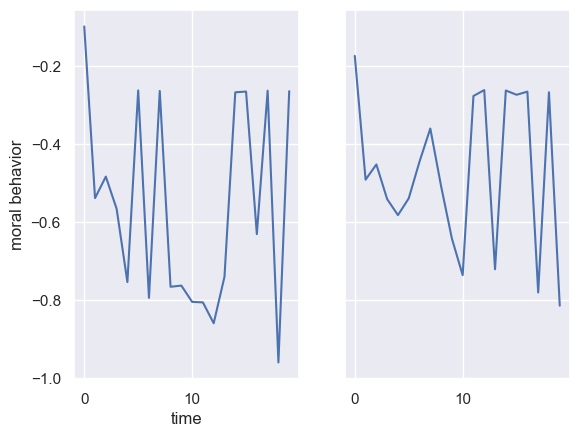

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
ax[0].plot(sample_agent_1.moral_behavior[:20])
ax[1].plot(sample_agent_2.moral_behavior[:20])
ax[0].set_ylabel('moral behavior')
ax[0].set_xlabel('time')

Text(0.5, 0, 'time')

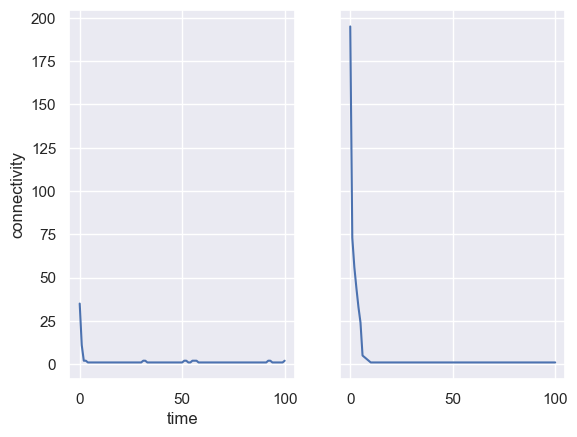

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
ax[0].plot(sample_agent_1.connectivity)
ax[1].plot(sample_agent_2.connectivity)
ax[0].set_ylabel('connectivity')
ax[0].set_xlabel('time')

Text(0.5, 0, 'time')

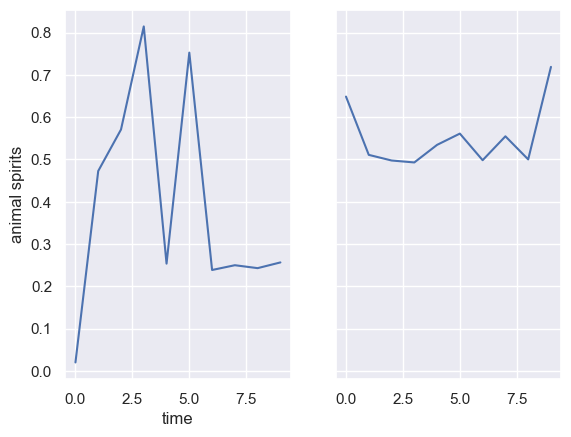

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey = True)
ax[0].plot(sample_agent_1.animal_spirits[:10])
ax[1].plot(sample_agent_2.animal_spirits[:10])
ax[0].set_ylabel('animal spirits')
ax[0].set_xlabel('time')

## Distributions

In [117]:
def create_partitions(arr, n):
  size = len(arr)

  if n >= size:
    return list(range(size))
  elif size == 1:
    return [0]
  else:
    return [int(np.floor(i*(size-1)/(n-1))) for i in range(n)]

def make_hist(col):
  global steps
  subsample_cross = create_partitions(range(df_model.shape[0]), 10)

  plt.figure(figsize=(22, 3))
  plt.subplots_adjust(hspace=0.2)
  plt.suptitle(f"{col} at t={[i for i in subsample_cross]}", fontsize=16, y=0.95)

  ncols = 5
  nrows = 2

  for n, ticker in enumerate(subsample_cross):
      ax = plt.subplot(nrows, ncols, n + 1)
      df_agents.loc[(ticker, slice(None)), col].hist(ax = ax, bins = 25)

In [118]:
cols = ['wealth', 'animal_spirits', 'political_view', 'moral_behavior', 'consumption', 'gen_skills']
for c in cols:
  make_hist(c)

NameError: name 'np' is not defined

Text(0, 0.5, 'Lifetime Consumption')

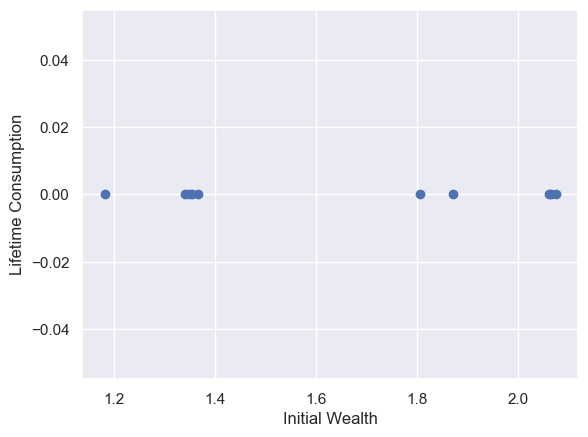

In [ ]:
agents_lifetime_consumption = df_agents['consumption'].unstack().sum()
agents_initial_wealth = df_agents['wealth'].unstack().iloc[0,:]

plt.scatter(y = agents_lifetime_consumption, x = agents_initial_wealth)
plt.xlabel('Initial Wealth')
plt.ylabel('Lifetime Consumption')

Text(0, 0.5, 'Lifetime Consumption')

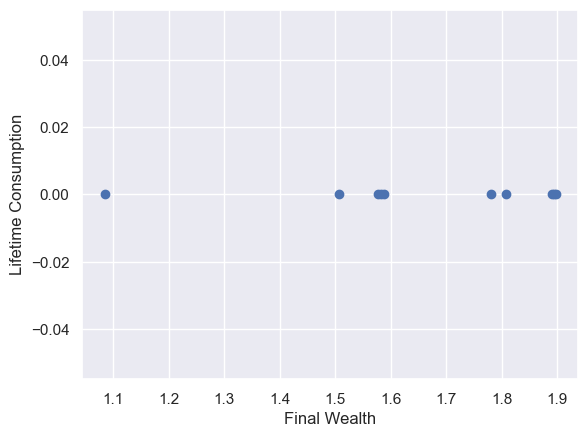

In [ ]:
agents_final_wealth = df_agents['wealth'].unstack().iloc[df_model.shape[0] - 1,:]

plt.scatter(y = agents_lifetime_consumption, x = agents_final_wealth)
plt.xlabel('Final Wealth')
plt.ylabel('Lifetime Consumption')